# A2C (train)
[Deep Reinforcement Learning with Policy Gradients and Actor-Critic Methods](https://www.datahubbs.com/policy-gradients-and-advantage-actor-critic/)  
[Two-Headed A2C Network in PyTorch](https://www.datahubbs.com/two-headed-a2c-network-in-pytorch/)

## 1. Setup

In [1]:
import config
import gym
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from collections import deque
from a2c import A2C
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0


## 2. Look at our env

In [2]:
env = gym.make(config.GAME_NAME)
state = env.reset()
print(f'Game: {config.GAME_NAME}')
print('A state (in env, not in our dqn) is represented by a frame')
print(type(state), state.dtype)
print(state.shape)

Game: Pong-v0
A state (in env, not in our dqn) is represented by a frame
<class 'numpy.ndarray'> uint8
(210, 160, 3)


In [3]:
print(f'Num_Actions: {env.action_space.n}')
action_meanings = env.unwrapped.get_action_meanings()
for i in range(env.action_space.n):
    print(f'{i}: {action_meanings[i]}')

Num_Actions: 6
0: NOOP
1: FIRE
2: RIGHT
3: LEFT
4: RIGHTFIRE
5: LEFTFIRE


__Look how the rgb frame is preprocessed__

initial: uint8
preprocessed_frame: float64, [0.245101470588235, 0.9254901960784314]


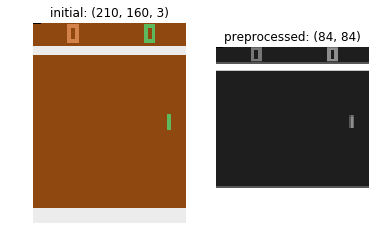

In [4]:
env.reset()
rgb_frame, _, _, _ = env.step(1)
preprocessed_frame = preprocess_frame(rgb_frame)

print(f'initial: {rgb_frame.dtype}')
print(f'preprocessed_frame: {preprocessed_frame.dtype}'
      f', [{preprocessed_frame.min()}, {preprocessed_frame.max()}]')

plt.figure()

plt.subplot(1, 2, 1)
plt.title(f'initial: {rgb_frame.shape}')
plt.axis('off')
plt.imshow(rgb_frame)

plt.subplot(1, 2, 2)
plt.title(f'preprocessed: {preprocessed_frame.shape}')
plt.axis('off')
plt.imshow(preprocessed_frame, cmap='gray')

plt.show()

## 3. A2C

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ReLU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ReLU)  
3. Conv2d(filters=64, kernel_size=3, strides=1, padding='valid', activation=ReLU) -> Flatten()  
4. FC(512, activation=ReLU)  
  - Actor: FC(NUM_ACTIONS, activation=Linear) + Softmax()  
  - Critic: FC(1, activation=Linear)

### Instantiate A2C net

In [5]:
tf.reset_default_graph()

a2c = A2C(action_size=env.action_space.n)

## 4. Training

### A2C (training algorithm)

In [6]:
def a2c_training(a2c, env):
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=50)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # some vars for train_stats
        step = 0
        iters_per_episode = []
        reward_per_episode = []
        actor_loss_per_iter = []
        critic_loss_per_iter = []
        
        for episode in range(1, config.NUM_EPISODES + 1):
            episode_step = 0
            done = False
            stacked_frames = None
            episode_rewards = []
            
            # new episode
            state = env.reset()
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, state,
                                                              is_new_episode=True)
            
            while not done:
                episode_step += 1
                step += 1
                
                # current state
                current_state = stacked_frames_hwc[:,:,-config.STACK_SIZE:]
                
                # get action probs from the actor
                action_probs = sess.run(a2c.predicted_probs,
                                        feed_dict={
                                            a2c.input_ph: current_state[np.newaxis]
                                        })
                
                # sample an action using action_probs
                action = np.random.choice(env.action_space.n, p=action_probs.squeeze())
                
                # take an action
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                
                # next_state
                stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                                  is_new_episode=False)
                next_state = stacked_frames_hwc[:,:,-config.STACK_SIZE:]                
                
                # prepare target for TD error
                td_target = None
                if done:
                    td_target = reward
                else:
                    next_state_value = sess.run(a2c.predicted_value,
                                                feed_dict={
                                                    a2c.input_ph: next_state[np.newaxis]
                                                })
                    td_target = reward + config.GAMMA * next_state_value.squeeze()
                
                # optimization
                optim_t = sess.run([a2c.actor_loss,
                                    a2c.critic_loss,
                                    a2c.actor_optimization_step,
                                    a2c.critic_optimization_step],
                                   feed_dict={
                                       a2c.input_ph: current_state[np.newaxis],
                                       a2c.action_ph: action,
                                       a2c.target_ph: td_target
                                   })
                
                actor_loss, critic_loss = optim_t[:2]
                
                actor_loss_per_iter.append(actor_loss.squeeze())
                critic_loss_per_iter.append(critic_loss.squeeze())
                
                if done:
                    # the end of episode
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Episode steps: {episode_step}\n'
                          f'Total training steps: {step}')                
                
            if (episode in [1, config.NUM_EPISODES]) or (episode % config.SAVE_EVERY == 0):
                saver.save(sess, f'{config.SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, actor_loss_per_iter, critic_loss_per_iter

In [7]:
%%time
!rm -rf $config.SAVE_PATH
train_stats = a2c_training(a2c, env)

Episode: 1, Total reward: -21.0, Episode steps: 1092
Total training steps: 1092
Model saved
Episode: 2, Total reward: -21.0, Episode steps: 1027
Total training steps: 2119
Episode: 3, Total reward: -20.0, Episode steps: 1226
Total training steps: 3345
Episode: 4, Total reward: -19.0, Episode steps: 1291
Total training steps: 4636
Episode: 5, Total reward: -21.0, Episode steps: 1046
Total training steps: 5682
Episode: 6, Total reward: -21.0, Episode steps: 1346
Total training steps: 7028
Episode: 7, Total reward: -21.0, Episode steps: 1119
Total training steps: 8147
Episode: 8, Total reward: -20.0, Episode steps: 1290
Total training steps: 9437
Episode: 9, Total reward: -21.0, Episode steps: 1006
Total training steps: 10443
Episode: 10, Total reward: -19.0, Episode steps: 1357
Total training steps: 11800
Episode: 11, Total reward: -21.0, Episode steps: 1030
Total training steps: 12830
Episode: 12, Total reward: -21.0, Episode steps: 1103
Total training steps: 13933
Episode: 13, Total re

Episode: 101, Total reward: -21.0, Episode steps: 1114
Total training steps: 113601
Episode: 102, Total reward: -21.0, Episode steps: 1006
Total training steps: 114607
Episode: 103, Total reward: -21.0, Episode steps: 1011
Total training steps: 115618
Episode: 104, Total reward: -21.0, Episode steps: 1022
Total training steps: 116640
Episode: 105, Total reward: -20.0, Episode steps: 1197
Total training steps: 117837
Episode: 106, Total reward: -21.0, Episode steps: 1022
Total training steps: 118859
Episode: 107, Total reward: -21.0, Episode steps: 1029
Total training steps: 119888
Episode: 108, Total reward: -21.0, Episode steps: 1018
Total training steps: 120906
Episode: 109, Total reward: -18.0, Episode steps: 1443
Total training steps: 122349
Episode: 110, Total reward: -20.0, Episode steps: 1160
Total training steps: 123509
Episode: 111, Total reward: -21.0, Episode steps: 1019
Total training steps: 124528
Episode: 112, Total reward: -20.0, Episode steps: 1219
Total training steps:

Episode: 199, Total reward: -21.0, Episode steps: 1020
Total training steps: 220576
Episode: 200, Total reward: -21.0, Episode steps: 1108
Total training steps: 221684
Model saved
Episode: 201, Total reward: -21.0, Episode steps: 1064
Total training steps: 222748
Episode: 202, Total reward: -21.0, Episode steps: 1171
Total training steps: 223919
Episode: 203, Total reward: -21.0, Episode steps: 1054
Total training steps: 224973
Episode: 204, Total reward: -21.0, Episode steps: 1013
Total training steps: 225986
Episode: 205, Total reward: -20.0, Episode steps: 1185
Total training steps: 227171
Episode: 206, Total reward: -20.0, Episode steps: 1196
Total training steps: 228367
Episode: 207, Total reward: -21.0, Episode steps: 1023
Total training steps: 229390
Episode: 208, Total reward: -21.0, Episode steps: 1186
Total training steps: 230576
Episode: 209, Total reward: -21.0, Episode steps: 1015
Total training steps: 231591
Episode: 210, Total reward: -21.0, Episode steps: 1012
Total tra

Episode: 297, Total reward: -21.0, Episode steps: 1015
Total training steps: 324823
Episode: 298, Total reward: -21.0, Episode steps: 1030
Total training steps: 325853
Episode: 299, Total reward: -21.0, Episode steps: 1015
Total training steps: 326868
Episode: 300, Total reward: -21.0, Episode steps: 1162
Total training steps: 328030
Model saved
Episode: 301, Total reward: -21.0, Episode steps: 1022
Total training steps: 329052
Episode: 302, Total reward: -21.0, Episode steps: 1015
Total training steps: 330067
Episode: 303, Total reward: -21.0, Episode steps: 1014
Total training steps: 331081
Episode: 304, Total reward: -21.0, Episode steps: 1027
Total training steps: 332108
Episode: 305, Total reward: -21.0, Episode steps: 1009
Total training steps: 333117
Episode: 306, Total reward: -21.0, Episode steps: 1024
Total training steps: 334141
Episode: 307, Total reward: -21.0, Episode steps: 1017
Total training steps: 335158
Episode: 308, Total reward: -21.0, Episode steps: 1020
Total tra

Episode: 395, Total reward: -21.0, Episode steps: 1013
Total training steps: 425163
Episode: 396, Total reward: -21.0, Episode steps: 1018
Total training steps: 426181
Episode: 397, Total reward: -21.0, Episode steps: 1001
Total training steps: 427182
Episode: 398, Total reward: -21.0, Episode steps: 1018
Total training steps: 428200
Episode: 399, Total reward: -21.0, Episode steps: 1027
Total training steps: 429227
Episode: 400, Total reward: -21.0, Episode steps: 1018
Total training steps: 430245
Model saved
Episode: 401, Total reward: -21.0, Episode steps: 1008
Total training steps: 431253
Episode: 402, Total reward: -21.0, Episode steps: 1013
Total training steps: 432266
Episode: 403, Total reward: -21.0, Episode steps: 1014
Total training steps: 433280
Episode: 404, Total reward: -21.0, Episode steps: 1014
Total training steps: 434294
Episode: 405, Total reward: -21.0, Episode steps: 1029
Total training steps: 435323
Episode: 406, Total reward: -21.0, Episode steps: 1011
Total tra

Episode: 493, Total reward: -21.0, Episode steps: 1010
Total training steps: 525009
Episode: 494, Total reward: -21.0, Episode steps: 1019
Total training steps: 526028
Episode: 495, Total reward: -21.0, Episode steps: 1009
Total training steps: 527037
Episode: 496, Total reward: -21.0, Episode steps: 1010
Total training steps: 528047
Episode: 497, Total reward: -21.0, Episode steps: 1016
Total training steps: 529063
Episode: 498, Total reward: -21.0, Episode steps: 1018
Total training steps: 530081
Episode: 499, Total reward: -21.0, Episode steps: 1010
Total training steps: 531091
Episode: 500, Total reward: -21.0, Episode steps: 1013
Total training steps: 532104
Model saved
Episode: 501, Total reward: -21.0, Episode steps: 1020
Total training steps: 533124
Episode: 502, Total reward: -21.0, Episode steps: 1019
Total training steps: 534143
Episode: 503, Total reward: -21.0, Episode steps: 1012
Total training steps: 535155
Episode: 504, Total reward: -21.0, Episode steps: 1022
Total tra

Episode: 591, Total reward: -21.0, Episode steps: 1020
Total training steps: 624904
Episode: 592, Total reward: -21.0, Episode steps: 1030
Total training steps: 625934
Episode: 593, Total reward: -21.0, Episode steps: 1021
Total training steps: 626955
Episode: 594, Total reward: -21.0, Episode steps: 1004
Total training steps: 627959
Episode: 595, Total reward: -21.0, Episode steps: 1014
Total training steps: 628973
Episode: 596, Total reward: -21.0, Episode steps: 1002
Total training steps: 629975
Episode: 597, Total reward: -21.0, Episode steps: 1003
Total training steps: 630978
Episode: 598, Total reward: -21.0, Episode steps: 1024
Total training steps: 632002
Episode: 599, Total reward: -21.0, Episode steps: 1017
Total training steps: 633019
Episode: 600, Total reward: -21.0, Episode steps: 1028
Total training steps: 634047
Model saved
Episode: 601, Total reward: -21.0, Episode steps: 1007
Total training steps: 635054
Episode: 602, Total reward: -21.0, Episode steps: 1020
Total tra

Episode: 689, Total reward: -21.0, Episode steps: 1010
Total training steps: 724765
Episode: 690, Total reward: -21.0, Episode steps: 1018
Total training steps: 725783
Episode: 691, Total reward: -21.0, Episode steps: 1031
Total training steps: 726814
Episode: 692, Total reward: -21.0, Episode steps: 1034
Total training steps: 727848
Episode: 693, Total reward: -21.0, Episode steps: 1014
Total training steps: 728862
Episode: 694, Total reward: -21.0, Episode steps: 1020
Total training steps: 729882
Episode: 695, Total reward: -21.0, Episode steps: 1027
Total training steps: 730909
Episode: 696, Total reward: -21.0, Episode steps: 1041
Total training steps: 731950
Episode: 697, Total reward: -21.0, Episode steps: 1026
Total training steps: 732976
Episode: 698, Total reward: -21.0, Episode steps: 1013
Total training steps: 733989
Episode: 699, Total reward: -21.0, Episode steps: 1018
Total training steps: 735007
Episode: 700, Total reward: -21.0, Episode steps: 1020
Total training steps:

Episode: 787, Total reward: -21.0, Episode steps: 1034
Total training steps: 824720
Episode: 788, Total reward: -21.0, Episode steps: 1025
Total training steps: 825745
Episode: 789, Total reward: -21.0, Episode steps: 1018
Total training steps: 826763
Episode: 790, Total reward: -21.0, Episode steps: 1020
Total training steps: 827783
Episode: 791, Total reward: -21.0, Episode steps: 1020
Total training steps: 828803
Episode: 792, Total reward: -21.0, Episode steps: 1018
Total training steps: 829821
Episode: 793, Total reward: -21.0, Episode steps: 1028
Total training steps: 830849
Episode: 794, Total reward: -21.0, Episode steps: 1012
Total training steps: 831861
Episode: 795, Total reward: -21.0, Episode steps: 1016
Total training steps: 832877
Episode: 796, Total reward: -21.0, Episode steps: 1006
Total training steps: 833883
Episode: 797, Total reward: -21.0, Episode steps: 1025
Total training steps: 834908
Episode: 798, Total reward: -21.0, Episode steps: 1019
Total training steps:

Episode: 885, Total reward: -21.0, Episode steps: 1035
Total training steps: 924623
Episode: 886, Total reward: -21.0, Episode steps: 1029
Total training steps: 925652
Episode: 887, Total reward: -21.0, Episode steps: 1014
Total training steps: 926666
Episode: 888, Total reward: -21.0, Episode steps: 1027
Total training steps: 927693
Episode: 889, Total reward: -21.0, Episode steps: 1019
Total training steps: 928712
Episode: 890, Total reward: -21.0, Episode steps: 1020
Total training steps: 929732
Episode: 891, Total reward: -21.0, Episode steps: 1016
Total training steps: 930748
Episode: 892, Total reward: -21.0, Episode steps: 1011
Total training steps: 931759
Episode: 893, Total reward: -21.0, Episode steps: 1036
Total training steps: 932795
Episode: 894, Total reward: -21.0, Episode steps: 1016
Total training steps: 933811
Episode: 895, Total reward: -21.0, Episode steps: 1021
Total training steps: 934832
Episode: 896, Total reward: -21.0, Episode steps: 1024
Total training steps:

Episode: 983, Total reward: -21.0, Episode steps: 1024
Total training steps: 1024491
Episode: 984, Total reward: -21.0, Episode steps: 1020
Total training steps: 1025511
Episode: 985, Total reward: -21.0, Episode steps: 1026
Total training steps: 1026537
Episode: 986, Total reward: -21.0, Episode steps: 1030
Total training steps: 1027567
Episode: 987, Total reward: -21.0, Episode steps: 1023
Total training steps: 1028590
Episode: 988, Total reward: -21.0, Episode steps: 1040
Total training steps: 1029630
Episode: 989, Total reward: -21.0, Episode steps: 1008
Total training steps: 1030638
Episode: 990, Total reward: -21.0, Episode steps: 1026
Total training steps: 1031664
Episode: 991, Total reward: -21.0, Episode steps: 1022
Total training steps: 1032686
Episode: 992, Total reward: -21.0, Episode steps: 1023
Total training steps: 1033709
Episode: 993, Total reward: -21.0, Episode steps: 1023
Total training steps: 1034732
Episode: 994, Total reward: -21.0, Episode steps: 1021
Total trai

Episode: 1079, Total reward: -21.0, Episode steps: 1024
Total training steps: 1122435
Episode: 1080, Total reward: -21.0, Episode steps: 1018
Total training steps: 1123453
Episode: 1081, Total reward: -21.0, Episode steps: 1016
Total training steps: 1124469
Episode: 1082, Total reward: -21.0, Episode steps: 1021
Total training steps: 1125490
Episode: 1083, Total reward: -21.0, Episode steps: 1025
Total training steps: 1126515
Episode: 1084, Total reward: -21.0, Episode steps: 1007
Total training steps: 1127522
Episode: 1085, Total reward: -21.0, Episode steps: 1027
Total training steps: 1128549
Episode: 1086, Total reward: -21.0, Episode steps: 1030
Total training steps: 1129579
Episode: 1087, Total reward: -21.0, Episode steps: 1019
Total training steps: 1130598
Episode: 1088, Total reward: -21.0, Episode steps: 1017
Total training steps: 1131615
Episode: 1089, Total reward: -21.0, Episode steps: 1021
Total training steps: 1132636
Episode: 1090, Total reward: -21.0, Episode steps: 101

Episode: 1174, Total reward: -21.0, Episode steps: 1017
Total training steps: 1219372
Episode: 1175, Total reward: -21.0, Episode steps: 1023
Total training steps: 1220395
Episode: 1176, Total reward: -21.0, Episode steps: 1029
Total training steps: 1221424
Episode: 1177, Total reward: -21.0, Episode steps: 1018
Total training steps: 1222442
Episode: 1178, Total reward: -21.0, Episode steps: 1018
Total training steps: 1223460
Episode: 1179, Total reward: -21.0, Episode steps: 1016
Total training steps: 1224476
Episode: 1180, Total reward: -21.0, Episode steps: 1014
Total training steps: 1225490
Episode: 1181, Total reward: -21.0, Episode steps: 1015
Total training steps: 1226505
Episode: 1182, Total reward: -21.0, Episode steps: 1027
Total training steps: 1227532
Episode: 1183, Total reward: -21.0, Episode steps: 1025
Total training steps: 1228557
Episode: 1184, Total reward: -21.0, Episode steps: 1016
Total training steps: 1229573
Episode: 1185, Total reward: -21.0, Episode steps: 102

Episode: 1270, Total reward: -21.0, Episode steps: 1026
Total training steps: 1317355
Episode: 1271, Total reward: -21.0, Episode steps: 1022
Total training steps: 1318377
Episode: 1272, Total reward: -21.0, Episode steps: 1034
Total training steps: 1319411
Episode: 1273, Total reward: -21.0, Episode steps: 1004
Total training steps: 1320415
Episode: 1274, Total reward: -21.0, Episode steps: 1006
Total training steps: 1321421
Episode: 1275, Total reward: -21.0, Episode steps: 1015
Total training steps: 1322436
Episode: 1276, Total reward: -21.0, Episode steps: 1022
Total training steps: 1323458
Episode: 1277, Total reward: -21.0, Episode steps: 1029
Total training steps: 1324487
Episode: 1278, Total reward: -21.0, Episode steps: 1012
Total training steps: 1325499
Episode: 1279, Total reward: -21.0, Episode steps: 1027
Total training steps: 1326526
Episode: 1280, Total reward: -21.0, Episode steps: 1028
Total training steps: 1327554
Episode: 1281, Total reward: -21.0, Episode steps: 101

Episode: 1365, Total reward: -21.0, Episode steps: 1029
Total training steps: 1414178
Episode: 1366, Total reward: -21.0, Episode steps: 1028
Total training steps: 1415206
Episode: 1367, Total reward: -21.0, Episode steps: 1007
Total training steps: 1416213
Episode: 1368, Total reward: -21.0, Episode steps: 1032
Total training steps: 1417245
Episode: 1369, Total reward: -21.0, Episode steps: 1022
Total training steps: 1418267
Episode: 1370, Total reward: -21.0, Episode steps: 1008
Total training steps: 1419275
Episode: 1371, Total reward: -21.0, Episode steps: 1011
Total training steps: 1420286
Episode: 1372, Total reward: -21.0, Episode steps: 1017
Total training steps: 1421303
Episode: 1373, Total reward: -21.0, Episode steps: 1023
Total training steps: 1422326
Episode: 1374, Total reward: -21.0, Episode steps: 1017
Total training steps: 1423343
Episode: 1375, Total reward: -21.0, Episode steps: 1017
Total training steps: 1424360
Episode: 1376, Total reward: -21.0, Episode steps: 102

Episode: 1460, Total reward: -21.0, Episode steps: 1017
Total training steps: 1510876
Episode: 1461, Total reward: -21.0, Episode steps: 1031
Total training steps: 1511907
Episode: 1462, Total reward: -21.0, Episode steps: 1005
Total training steps: 1512912
Episode: 1463, Total reward: -21.0, Episode steps: 1000
Total training steps: 1513912
Episode: 1464, Total reward: -21.0, Episode steps: 1015
Total training steps: 1514927
Episode: 1465, Total reward: -21.0, Episode steps: 1010
Total training steps: 1515937
Episode: 1466, Total reward: -21.0, Episode steps: 1013
Total training steps: 1516950
Episode: 1467, Total reward: -21.0, Episode steps: 1015
Total training steps: 1517965
Episode: 1468, Total reward: -21.0, Episode steps: 1012
Total training steps: 1518977
Episode: 1469, Total reward: -21.0, Episode steps: 1009
Total training steps: 1519986
Episode: 1470, Total reward: -21.0, Episode steps: 1017
Total training steps: 1521003
Episode: 1471, Total reward: -21.0, Episode steps: 101

Episode: 1555, Total reward: -21.0, Episode steps: 1026
Total training steps: 1607806
Episode: 1556, Total reward: -21.0, Episode steps: 1024
Total training steps: 1608830
Episode: 1557, Total reward: -21.0, Episode steps: 1023
Total training steps: 1609853
Episode: 1558, Total reward: -21.0, Episode steps: 1029
Total training steps: 1610882
Episode: 1559, Total reward: -21.0, Episode steps: 1032
Total training steps: 1611914
Episode: 1560, Total reward: -21.0, Episode steps: 1014
Total training steps: 1612928
Episode: 1561, Total reward: -21.0, Episode steps: 1018
Total training steps: 1613946
Episode: 1562, Total reward: -21.0, Episode steps: 1019
Total training steps: 1614965
Episode: 1563, Total reward: -21.0, Episode steps: 1014
Total training steps: 1615979
Episode: 1564, Total reward: -21.0, Episode steps: 1005
Total training steps: 1616984
Episode: 1565, Total reward: -21.0, Episode steps: 1012
Total training steps: 1617996
Episode: 1566, Total reward: -21.0, Episode steps: 100

Episode: 1651, Total reward: -21.0, Episode steps: 1017
Total training steps: 1705710
Episode: 1652, Total reward: -21.0, Episode steps: 1026
Total training steps: 1706736
Episode: 1653, Total reward: -21.0, Episode steps: 1024
Total training steps: 1707760
Episode: 1654, Total reward: -21.0, Episode steps: 1006
Total training steps: 1708766
Episode: 1655, Total reward: -21.0, Episode steps: 1020
Total training steps: 1709786
Episode: 1656, Total reward: -21.0, Episode steps: 1012
Total training steps: 1710798
Episode: 1657, Total reward: -21.0, Episode steps: 1032
Total training steps: 1711830
Episode: 1658, Total reward: -21.0, Episode steps: 1014
Total training steps: 1712844
Episode: 1659, Total reward: -21.0, Episode steps: 1023
Total training steps: 1713867
Episode: 1660, Total reward: -21.0, Episode steps: 1017
Total training steps: 1714884
Episode: 1661, Total reward: -21.0, Episode steps: 1012
Total training steps: 1715896
Episode: 1662, Total reward: -21.0, Episode steps: 100

Episode: 1747, Total reward: -21.0, Episode steps: 1023
Total training steps: 1803550
Episode: 1748, Total reward: -21.0, Episode steps: 1004
Total training steps: 1804554
Episode: 1749, Total reward: -21.0, Episode steps: 1017
Total training steps: 1805571
Episode: 1750, Total reward: -21.0, Episode steps: 1014
Total training steps: 1806585
Model saved
Episode: 1751, Total reward: -21.0, Episode steps: 1003
Total training steps: 1807588
Episode: 1752, Total reward: -21.0, Episode steps: 1035
Total training steps: 1808623
Episode: 1753, Total reward: -21.0, Episode steps: 1027
Total training steps: 1809650
Episode: 1754, Total reward: -21.0, Episode steps: 1021
Total training steps: 1810671
Episode: 1755, Total reward: -21.0, Episode steps: 1020
Total training steps: 1811691
Episode: 1756, Total reward: -21.0, Episode steps: 1009
Total training steps: 1812700
Episode: 1757, Total reward: -21.0, Episode steps: 1025
Total training steps: 1813725
Episode: 1758, Total reward: -21.0, Episod

Episode: 1843, Total reward: -21.0, Episode steps: 1021
Total training steps: 1901333
Episode: 1844, Total reward: -21.0, Episode steps: 1033
Total training steps: 1902366
Episode: 1845, Total reward: -21.0, Episode steps: 1026
Total training steps: 1903392
Episode: 1846, Total reward: -21.0, Episode steps: 1022
Total training steps: 1904414
Episode: 1847, Total reward: -21.0, Episode steps: 1020
Total training steps: 1905434
Episode: 1848, Total reward: -21.0, Episode steps: 1010
Total training steps: 1906444
Episode: 1849, Total reward: -21.0, Episode steps: 1012
Total training steps: 1907456
Episode: 1850, Total reward: -21.0, Episode steps: 1014
Total training steps: 1908470
Model saved
Episode: 1851, Total reward: -21.0, Episode steps: 1021
Total training steps: 1909491
Episode: 1852, Total reward: -21.0, Episode steps: 1016
Total training steps: 1910507
Episode: 1853, Total reward: -21.0, Episode steps: 999
Total training steps: 1911506
Episode: 1854, Total reward: -21.0, Episode

Episode: 1939, Total reward: -21.0, Episode steps: 1011
Total training steps: 1999153
Episode: 1940, Total reward: -21.0, Episode steps: 1016
Total training steps: 2000169
Episode: 1941, Total reward: -21.0, Episode steps: 1030
Total training steps: 2001199
Episode: 1942, Total reward: -21.0, Episode steps: 1011
Total training steps: 2002210
Episode: 1943, Total reward: -21.0, Episode steps: 1014
Total training steps: 2003224
Episode: 1944, Total reward: -21.0, Episode steps: 1026
Total training steps: 2004250
Episode: 1945, Total reward: -21.0, Episode steps: 1023
Total training steps: 2005273
Episode: 1946, Total reward: -21.0, Episode steps: 1026
Total training steps: 2006299
Episode: 1947, Total reward: -21.0, Episode steps: 1015
Total training steps: 2007314
Episode: 1948, Total reward: -21.0, Episode steps: 1012
Total training steps: 2008326
Episode: 1949, Total reward: -21.0, Episode steps: 1019
Total training steps: 2009345
Episode: 1950, Total reward: -21.0, Episode steps: 101

Episode: 2035, Total reward: -21.0, Episode steps: 1021
Total training steps: 2097047
Episode: 2036, Total reward: -21.0, Episode steps: 1043
Total training steps: 2098090
Episode: 2037, Total reward: -21.0, Episode steps: 1031
Total training steps: 2099121
Episode: 2038, Total reward: -21.0, Episode steps: 1006
Total training steps: 2100127
Episode: 2039, Total reward: -21.0, Episode steps: 1019
Total training steps: 2101146
Episode: 2040, Total reward: -21.0, Episode steps: 1015
Total training steps: 2102161
Episode: 2041, Total reward: -21.0, Episode steps: 1030
Total training steps: 2103191
Episode: 2042, Total reward: -21.0, Episode steps: 1026
Total training steps: 2104217
Episode: 2043, Total reward: -21.0, Episode steps: 1019
Total training steps: 2105236
Episode: 2044, Total reward: -21.0, Episode steps: 1012
Total training steps: 2106248
Episode: 2045, Total reward: -21.0, Episode steps: 1016
Total training steps: 2107264
Episode: 2046, Total reward: -21.0, Episode steps: 102

Episode: 2130, Total reward: -21.0, Episode steps: 1016
Total training steps: 2193930
Episode: 2131, Total reward: -21.0, Episode steps: 1022
Total training steps: 2194952
Episode: 2132, Total reward: -21.0, Episode steps: 1011
Total training steps: 2195963
Episode: 2133, Total reward: -21.0, Episode steps: 1020
Total training steps: 2196983
Episode: 2134, Total reward: -21.0, Episode steps: 1018
Total training steps: 2198001
Episode: 2135, Total reward: -21.0, Episode steps: 1009
Total training steps: 2199010
Episode: 2136, Total reward: -21.0, Episode steps: 1015
Total training steps: 2200025
Episode: 2137, Total reward: -21.0, Episode steps: 1033
Total training steps: 2201058
Episode: 2138, Total reward: -21.0, Episode steps: 1029
Total training steps: 2202087
Episode: 2139, Total reward: -21.0, Episode steps: 1015
Total training steps: 2203102
Episode: 2140, Total reward: -21.0, Episode steps: 1003
Total training steps: 2204105
Episode: 2141, Total reward: -21.0, Episode steps: 101

Episode: 2226, Total reward: -21.0, Episode steps: 1029
Total training steps: 2291686
Episode: 2227, Total reward: -21.0, Episode steps: 1028
Total training steps: 2292714
Episode: 2228, Total reward: -21.0, Episode steps: 1042
Total training steps: 2293756
Episode: 2229, Total reward: -21.0, Episode steps: 1020
Total training steps: 2294776
Episode: 2230, Total reward: -21.0, Episode steps: 1045
Total training steps: 2295821
Episode: 2231, Total reward: -21.0, Episode steps: 1029
Total training steps: 2296850
Episode: 2232, Total reward: -21.0, Episode steps: 1027
Total training steps: 2297877
Episode: 2233, Total reward: -21.0, Episode steps: 1017
Total training steps: 2298894
Episode: 2234, Total reward: -21.0, Episode steps: 1027
Total training steps: 2299921
Episode: 2235, Total reward: -21.0, Episode steps: 1022
Total training steps: 2300943
Episode: 2236, Total reward: -21.0, Episode steps: 1023
Total training steps: 2301966
Episode: 2237, Total reward: -21.0, Episode steps: 103

Episode: 2321, Total reward: -21.0, Episode steps: 1018
Total training steps: 2388646
Episode: 2322, Total reward: -21.0, Episode steps: 1024
Total training steps: 2389670
Episode: 2323, Total reward: -21.0, Episode steps: 1011
Total training steps: 2390681
Episode: 2324, Total reward: -21.0, Episode steps: 1019
Total training steps: 2391700
Episode: 2325, Total reward: -21.0, Episode steps: 1021
Total training steps: 2392721
Episode: 2326, Total reward: -21.0, Episode steps: 1011
Total training steps: 2393732
Episode: 2327, Total reward: -21.0, Episode steps: 1016
Total training steps: 2394748
Episode: 2328, Total reward: -21.0, Episode steps: 1014
Total training steps: 2395762
Episode: 2329, Total reward: -21.0, Episode steps: 1022
Total training steps: 2396784
Episode: 2330, Total reward: -21.0, Episode steps: 1015
Total training steps: 2397799
Episode: 2331, Total reward: -21.0, Episode steps: 1006
Total training steps: 2398805
Episode: 2332, Total reward: -21.0, Episode steps: 101

Episode: 2416, Total reward: -21.0, Episode steps: 1016
Total training steps: 2485535
Episode: 2417, Total reward: -21.0, Episode steps: 1014
Total training steps: 2486549
Episode: 2418, Total reward: -21.0, Episode steps: 1020
Total training steps: 2487569
Episode: 2419, Total reward: -21.0, Episode steps: 1016
Total training steps: 2488585
Episode: 2420, Total reward: -21.0, Episode steps: 1020
Total training steps: 2489605
Episode: 2421, Total reward: -21.0, Episode steps: 1011
Total training steps: 2490616
Episode: 2422, Total reward: -21.0, Episode steps: 1007
Total training steps: 2491623
Episode: 2423, Total reward: -21.0, Episode steps: 1014
Total training steps: 2492637
Episode: 2424, Total reward: -21.0, Episode steps: 1011
Total training steps: 2493648
Episode: 2425, Total reward: -21.0, Episode steps: 1028
Total training steps: 2494676
Episode: 2426, Total reward: -21.0, Episode steps: 1031
Total training steps: 2495707
Episode: 2427, Total reward: -21.0, Episode steps: 102

#### Training stats

In [8]:
iters_per_episode, reward_per_episode = train_stats[:2]
actor_loss_per_iter, critic_loss_per_iter = train_stats[2:]

#### Some plots

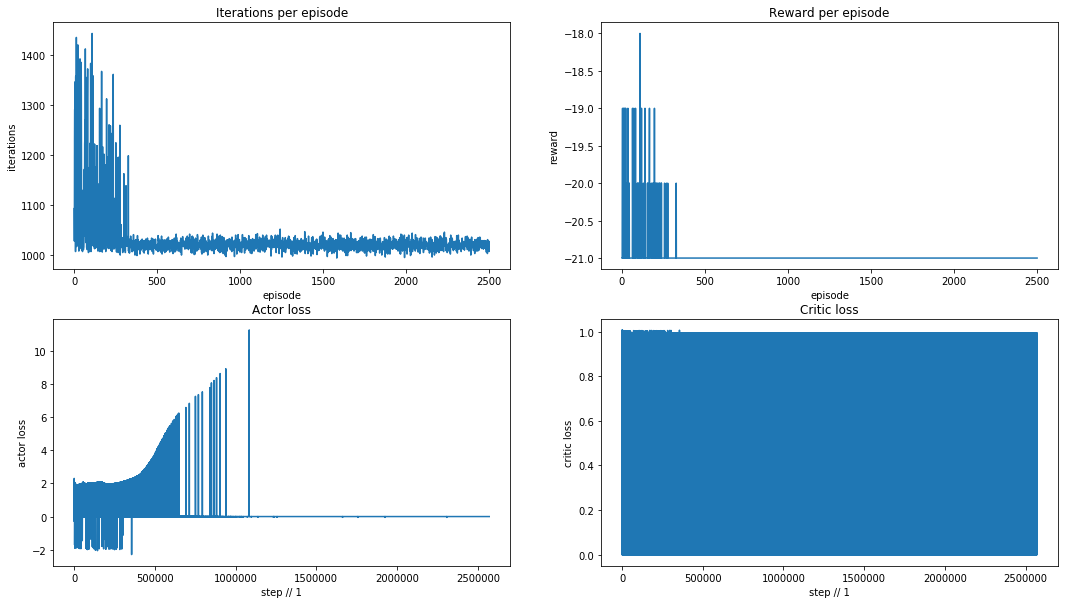

In [9]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(actor_loss_per_iter)) + 1
steps_to_skip = 1

plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(2, 2, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(2, 2, 3)
plt.title('Actor loss')
plt.plot(iter_range[::steps_to_skip] // steps_to_skip,
         actor_loss_per_iter[::steps_to_skip])
plt.ylabel('actor loss')
plt.xlabel(f'step // {steps_to_skip}')

plt.subplot(2, 2, 4)
plt.title('Critic loss')
plt.plot(iter_range[::steps_to_skip] // steps_to_skip,
         critic_loss_per_iter[::steps_to_skip])
plt.ylabel('critic loss')
plt.xlabel(f'step // {steps_to_skip}')
plt.show()